In [2]:
import numpy as np; import pandas as pd; import pyodbc; import datetime; import sklearn; import os; import math
from sklearn import feature_selection, linear_model, grid_search, cross_validation, metrics, ensemble, learning_curve 
from sklearn.preprocessing import scale
import seaborn as sns
from sklearn.manifold import TSNE
import pickle
import xgboost as xgb
from sklearn.feature_selection import chi2, f_classif, SelectKBest
from sklearn.preprocessing import StandardScaler
%pylab inline 
import sys
import warnings
conn = pyodbc.connect(r'DRIVER={SQL Server Native Client 11.0};'r'SERVER=WIN-5G5AUOCEJPK;'r'DATABASE=Gold585;'r'Trusted_Connection=yes;')

if not sys.warnoptions:
    warnings.simplefilter("ignore")
    
from IPython.core.display import display,HTML

display(HTML("<style>.container{width:90% !important;}</style>"))

Populating the interactive namespace from numpy and matplotlib


In [3]:
sql_query = "SELECT Code, \
      [PartnerID] \
      ,IIf([Sex]='M',1,IIf([Sex]='F',0,NULL)) Sex \
      ,Age,CreditCondition,LombardRating,SumAmountzb,AVGAmountzb,ZB,Good,PercentGood,IIF(PromotionID = 0,0,1) Promo,QntNew,QntPerez,QntOSN,QntBuyUp, \
      AVGDneyZaloga,AVGDneySProshZB,AVGWeightGross,AVGCostPerGram,AVGCost,AVGPercentPerDay,MINPercentPerDay,MAXPercentPerDay, \
      OverPayAmount,BudetSledVisit3M,BudetSledVisit6M,BudetSledVisit12M \
  FROM [Gold585].[dbo].[CommonTable] \
  Where IssueDate > convert(datetime,'2015-01-01') and IssueDate < convert(datetime,'2018-06-01') and Category in ('Новая cсуда')"
data = pd.read_sql(sql_query,conn)

In [127]:
sql_query = "SELECT Code, \
      [PartnerID] \
      ,IIf([Sex]='M',1,IIf([Sex]='F',0,NULL)) Sex \
      ,Age \
      ,CreditCondition \
      ,LombardRating \
      ,SumAmountzb \
      ,AVGAmountzb \
      ,ZB \
      ,Good \
      ,PercentGood \
      ,IIF(PromotionID = 0,0,1) Promo \
      ,QntNew \
      ,QntPerez \
      ,QntOSN \
      ,QntBuyUp \
      ,AVGDneyZaloga \
      ,AVGDneySProshZB \
      ,AVGWeightGross \
      ,AVGCostPerGram \
      ,AVGCost \
      ,AVGPercentPerDay \
      ,MINPercentPerDay \
      ,MAXPercentPerDay \
      ,OverPayAmount \
      ,BudetSledVisit3M \
      ,BudetSledVisit6M \
      ,BudetSledVisit12M \
  FROM [Gold585].[dbo].[CommonTable] a \
  Where IssueDate > convert(datetime,'2015-01-01') and IssueDate < convert(datetime,'2018-06-01') and Category in ('Новая cсуда')\
  and IssueDateTime = (select max(IssueDateTime) from [CommonTable] b where a.[PartnerID] =b.[PartnerID] and b.Category in ('Новая cсуда') and b.IssueDate < convert(datetime,'2018-06-01'))"
data = pd.read_sql(sql_query,conn)

In [111]:
sql_query = "SELECT Code, \
      [PartnerID] \
      ,CreditCondition,LombardRating,SumAmountzb,AVGAmountzb,ZB,PercentGood,IIF(PromotionID = 0,0,1) Promo,QntPerez,QntBuyUp,AVGDneyZaloga,AVGWeightGross,AVGCost,AVGPercentPerDay,MINPercentPerDay\
      ,BudetSledVisit3M,BudetSledVisit6M,BudetSledVisit12M,BudetSlednew3M,BudetSlednew6M,BudetSlednew12M \
  FROM [Gold585].[dbo].[CommonTable] a \
  Where IssueDate > convert(datetime,'2015-01-01') and IssueDate < convert(datetime,'2018-06-01') and Category in ('Новая cсуда')\
  and IssueDateTime = (select max(IssueDateTime) from [CommonTable] b where a.[PartnerID] =b.[PartnerID] and b.Category in ('Новая cсуда') and b.IssueDate < convert(datetime,'2018-06-01'))"
data = pd.read_sql(sql_query,conn)

In [4]:
data.head()

,Code,PartnerID,Sex,Age,CreditCondition,LombardRating,SumAmountzb,AVGAmountzb,ZB,Good,...,AVGWeightGross,AVGCostPerGram,AVGCost,AVGPercentPerDay,MINPercentPerDay,MAXPercentPerDay,OverPayAmount,BudetSledVisit3M,BudetSledVisit6M,BudetSledVisit12M
0,930002411764,97729,0.0,52,3,0,38690.0,2418.125000,16,16,...,2.8600,848.755310,2391.050049,0.3212,0.24,0.4,0.0,1,1,1
1,930004127840,97729,0.0,53,3,0,70387.0,3519.350098,20,19,...,3.6790,919.034790,3544.540039,0.3295,0.24,0.4,0.0,1,1,1
2,620000564686,97729,0.0,54,2,0,112187.0,4674.458496,24,23,...,4.4504,963.996887,4699.408203,0.3304,0.24,0.4,0.0,1,1,1
3,620000942404,97729,0.0,54,2,0,126007.0,4500.250000,28,27,...,4.1864,1019.464294,4525.957031,0.3332,0.24,0.4,0.0,1,1,1
4,620001148804,97729,0.0,54,3,0,153867.0,4808.343750,32,30,...,4.3140,1063.169312,4832.493652,0.3331,0.24,0.4,0.0,1,1,1


In [5]:
data.Promo.describe()

count    2.330990e+06
mean     1.570007e-01
std      3.638015e-01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.000000e+00
Name: Promo, dtype: float64

In [6]:
data.shape

(2330990, 28)

In [131]:
#df = data.sample(100000,axis=0).fillna(0)

In [132]:
df = data.fillna(0)

In [134]:
target=df.drop(['Code','PartnerID','BudetSledVisit3M','BudetSledVisit6M','BudetSledVisit12M'], axis=1)

In [135]:
target = pd.get_dummies(target, columns = ['Sex','CreditCondition','LombardRating'])

In [136]:
X = StandardScaler().fit_transform(target)

In [137]:
from sklearn.decomposition import PCA
# PCA
pca = PCA(n_components=2) #HOW MANY AXIS DO WE WANT
pca.fit_transform(X)
targert2 = pca.transform(X)

# TABLE WITH COMBINATIONS OF OLD FEATURES
print(pd.DataFrame(pca.components_,columns=target.columns, index = ['PC-1','PC-2']))#NUM INDEX EQUAL TO ALALALALAALL

           Age  SumAmountzb  AVGAmountzb        ZB      Good  PercentGood  \
PC-1  0.079940     0.251535     0.115027  0.392785  0.389824     0.208054   
PC-2  0.180143     0.105065     0.249164  0.038704  0.046865    -0.044065   

         Promo    QntNew  QntPerez    QntOSN       ...         \
PC-1 -0.028008  0.347999  0.354606  0.040931       ...          
PC-2  0.300594  0.004702  0.063654 -0.032184       ...          

      CreditCondition_8  LombardRating_0  LombardRating_1  LombardRating_2  \
PC-1           0.101683        -0.185845        -0.025910         0.032459   
PC-2           0.020804         0.385820        -0.160101        -0.224704   

      LombardRating_3  LombardRating_4  LombardRating_5  LombardRating_6  \
PC-1         0.073981         0.113621         0.162783         0.029943   
PC-2        -0.100203        -0.051022        -0.012511        -0.056709   

      LombardRating_7  LombardRating_8  
PC-1         0.004123         0.059731  
PC-2        -0.044311     

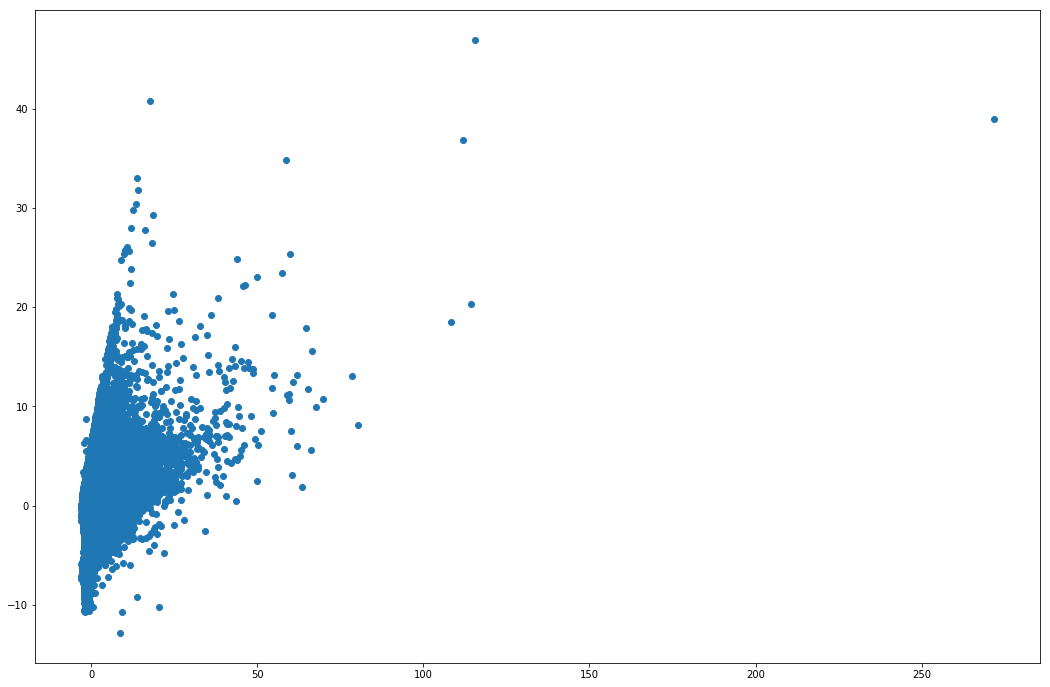

In [138]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 18
fig_size[1] = 12

plt.scatter(targert2[:, 0], targert2[:, 1])

In [139]:
targert2.shape

(556398, 2)

In [188]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=6, random_state=42).fit(X)
labels = kmeans.predict(X)


In [189]:
df['labels']=pd.DataFrame(labels)

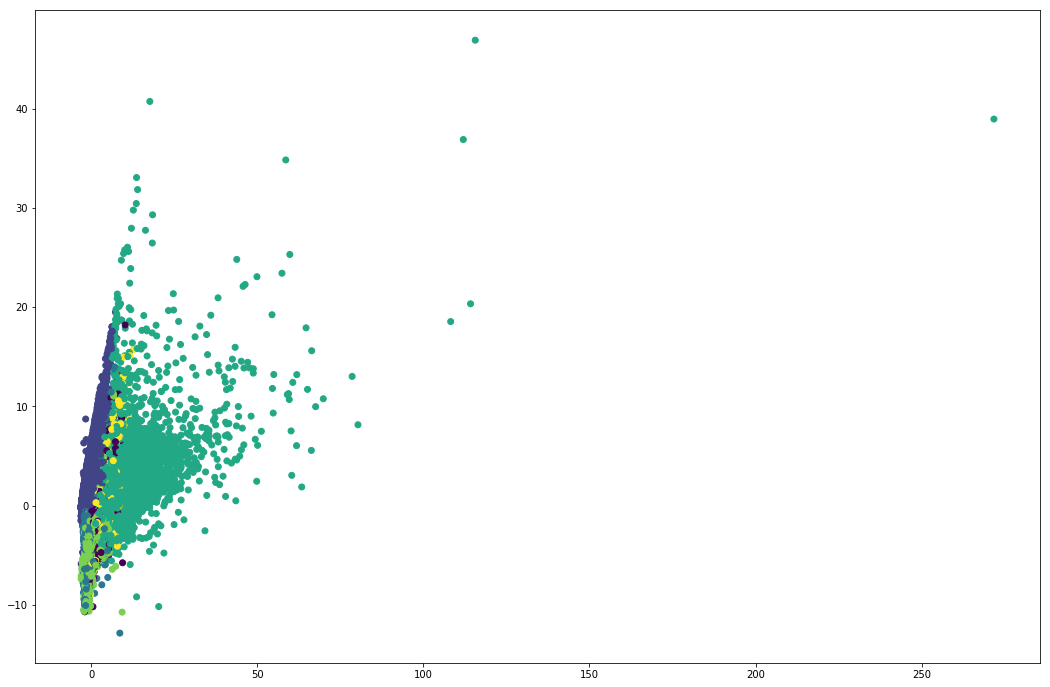

In [190]:

targert2 = pd.DataFrame(targert2,columns=('X','Y'))
targert2['L'] = pd.DataFrame(labels)

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 18
fig_size[1] = 12

plt.scatter(targert2['X'], targert2['Y'],c =labels)

In [195]:
#удалим кластер с выбросами и проанализируем еще раз
print(df[df['labels']==0].shape[0])
print(df[df['labels']==1].shape[0])
print(df[df['labels']==2].shape[0])
print(df[df['labels']==3].shape[0])
print(df[df['labels']==4].shape[0])
print(df[df['labels']==5].shape[0])

41884
245391
91751
36644
101961
38767


In [192]:
df[df['labels']==0].describe()

,PartnerID,Sex,Age,CreditCondition,LombardRating,SumAmountzb,AVGAmountzb,ZB,Good,PercentGood,...,AVGCostPerGram,AVGCost,AVGPercentPerDay,MINPercentPerDay,MAXPercentPerDay,OverPayAmount,BudetSledVisit3M,BudetSledVisit6M,BudetSledVisit12M,labels
count,4.188400e+04,41884.000000,41884.000000,41884.000000,41884.000000,4.188400e+04,41884.000000,41884.000000,41884.000000,41884.000000,...,41884.000000,41884.000000,41884.000000,41884.000000,41884.000000,41884.000000,41884.000000,41884.000000,41884.000000,41884.0
mean,1.245613e+06,0.353452,36.056418,2.938425,2.875967,9.309710e+04,6923.488830,12.833779,10.964115,81.082436,...,1102.584861,7564.523776,0.342562,0.282728,0.399179,15.568940,0.485651,0.513490,0.546151,0.0
std,1.067927e+06,0.478047,10.559079,0.544691,1.065402,1.947620e+05,8993.884125,12.518651,11.931738,24.330898,...,206.722369,9931.623213,0.069667,0.069326,0.169916,337.979717,0.499800,0.499824,0.497871,0.0
min,7.800000e+01,0.000000,-3.000000,0.000000,0.000000,6.750000e+02,459.231415,1.000000,0.000000,0.000000,...,0.000000,520.153809,0.145000,0.110000,0.150000,0.000000,0.000000,0.000000,0.000000,0.0
25%,2.270705e+05,0.000000,28.000000,3.000000,3.000000,1.850000e+04,2751.099976,5.000000,4.000000,72.727272,...,957.888824,2979.000000,0.298800,0.240000,0.350000,0.000000,0.000000,0.000000,0.000000,0.0
50%,1.197920e+06,0.000000,34.000000,3.000000,3.000000,3.801050e+04,4421.973389,7.000000,6.000000,89.473686,...,1096.276611,4786.514160,0.333500,0.270000,0.390000,0.000000,0.000000,1.000000,1.000000,0.0
75%,1.776429e+06,1.000000,43.000000,3.000000,3.000000,9.059549e+04,7676.087524,15.000000,13.000000,100.000000,...,1252.709961,8332.354248,0.376200,0.340000,0.400000,0.000000,1.000000,1.000000,1.000000,0.0
max,5.675417e+06,1.000000,90.000000,7.000000,7.000000,5.199538e+06,243552.640625,140.000000,117.000000,100.000000,...,5771.789062,333849.750000,2.228000,0.600000,2.700000,20424.000000,1.000000,1.000000,1.000000,0.0


In [200]:
#Выделим тех у кого 1 ЗБ в первом кластере в отдельный кластер (11)
df['labels'][(df['ZB']==1) & (df['labels']==1)] = 11

In [202]:
pd.concat([ df[df['labels']==11].describe().T['50%'],df[df['labels']==11].describe().T['mean'], \
            df[df['labels']==1].describe().T['50%'],df[df['labels']==1].describe().T['mean']], axis=1).to_csv('Sep first claster.csv')

In [203]:
#удалим кластер с выбросами и проанализируем еще раз
print(df[df['labels']==11].shape[0])
print(df[df['labels']==1].shape[0])


189854
55537


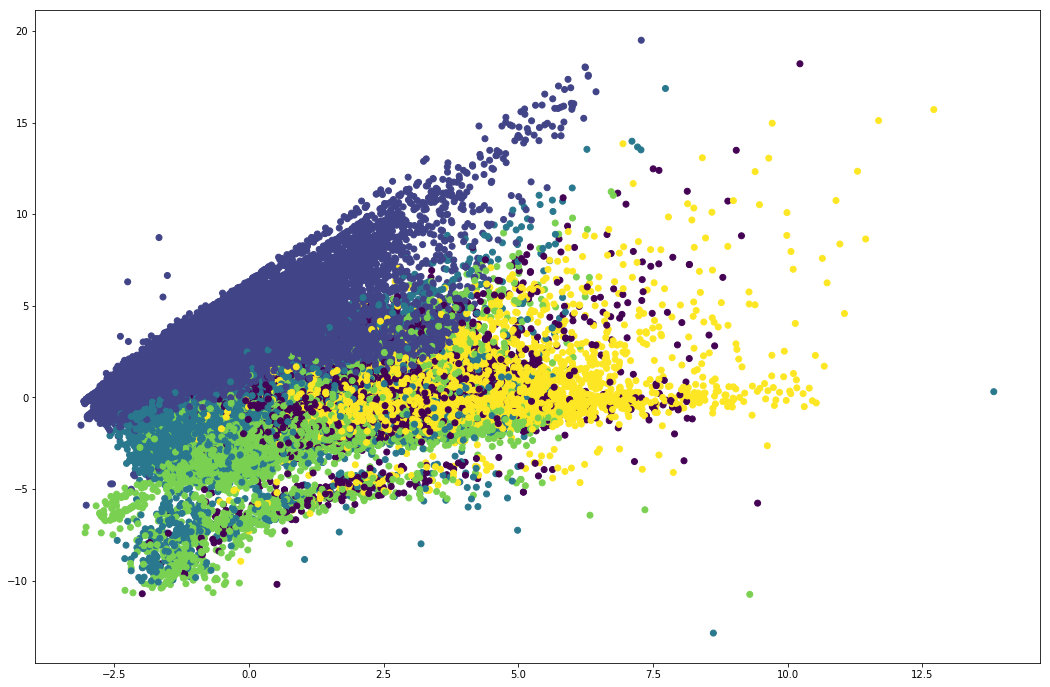

In [150]:
targert3=targert2[targert2['L']!=3]
plt.scatter(targert3['X'], targert3['Y'],c =targert3['L'])

In [160]:
pd.concat([ df[df['labels']==0].describe().T['50%'],df[df['labels']==0].describe().T['mean'], \
           df[df['labels']==1].describe().T['50%'],df[df['labels']==1].describe().T['mean'], df[df['labels']==2].describe().T['50%'],df[df['labels']==2].describe().T['mean'], \
           df[df['labels']==3].describe().T['50%'],df[df['labels']==3].describe().T['mean'], df[df['labels']==4].describe().T['50%'],df[df['labels']==4].describe().T['mean'], \
          df[df['labels']==5].describe().T['50%'],df[df['labels']==5].describe().T['mean']с

In [151]:
df[df['labels']==3].describe()

,PartnerID,Sex,Age,CreditCondition,LombardRating,SumAmountzb,AVGAmountzb,ZB,Good,PercentGood,...,AVGCostPerGram,AVGCost,AVGPercentPerDay,MINPercentPerDay,MAXPercentPerDay,OverPayAmount,BudetSledVisit3M,BudetSledVisit6M,BudetSledVisit12M,labels
count,3.664400e+04,36644.000000,36644.000000,36644.000000,36644.000000,3.664400e+04,36644.000000,36644.000000,36644.000000,36644.000000,...,36644.000000,36644.000000,36644.000000,36644.000000,36644.000000,3.664400e+04,36644.000000,36644.000000,36644.000000,36644.0
mean,7.505733e+05,0.282939,41.208738,4.143789,3.975876,6.175332e+05,11059.989643,52.814594,49.218426,92.847683,...,1097.363797,12005.865667,0.312058,0.244478,0.395731,4.736571e+03,0.686688,0.735946,0.755594,3.0
std,7.732705e+05,0.450433,11.682313,1.902685,1.955141,2.113775e+06,19804.672754,66.207104,61.211797,13.141820,...,193.622712,20989.513709,0.059794,0.056178,0.198891,2.416846e+04,0.463846,0.440834,0.429740,0.0
min,2.190000e+02,0.000000,-3.000000,0.000000,0.000000,9.362000e+02,312.066589,1.000000,0.000000,0.000000,...,0.000000,704.636292,0.136000,0.110000,0.150000,0.000000e+00,0.000000,0.000000,0.000000,3.0
25%,9.429075e+04,0.000000,32.000000,4.000000,3.000000,9.512721e+04,4018.526184,16.000000,15.000000,91.666664,...,975.065674,4397.792480,0.270900,0.200000,0.350000,0.000000e+00,0.000000,0.000000,1.000000,3.0
50%,2.899835e+05,0.000000,40.000000,5.000000,5.000000,2.249984e+05,6270.197754,32.000000,30.000000,97.727272,...,1091.956421,6869.250000,0.304000,0.240000,0.360000,5.670000e+02,1.000000,1.000000,1.000000,3.0
75%,1.384190e+06,1.000000,50.000000,5.000000,5.000000,5.232026e+05,10850.796143,72.000000,68.000000,100.000000,...,1210.314972,11823.487793,0.343000,0.270000,0.400000,2.123625e+03,1.000000,1.000000,1.000000,3.0
max,5.508305e+06,1.000000,88.000000,8.000000,8.000000,1.597028e+08,632800.000000,4197.000000,4196.000000,100.000000,...,7408.088379,632852.000000,0.713300,0.470000,2.700000,1.300502e+06,1.000000,1.000000,1.000000,3.0


In [152]:
df1 = df[df['labels']!= 3]

In [153]:
target1=df1.drop(['Code','PartnerID','BudetSledVisit3M','BudetSledVisit6M','BudetSledVisit12M','labels'], axis=1)

In [154]:
X1 = StandardScaler().fit_transform(target1)

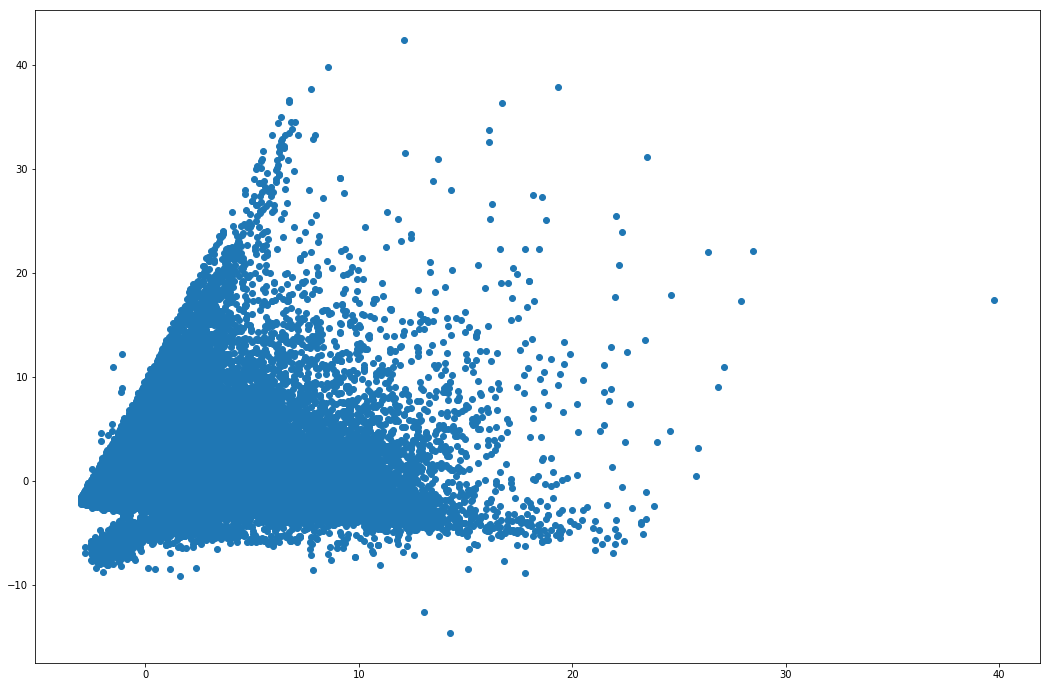

In [155]:
from sklearn.decomposition import PCA
# PCA
pca = PCA(n_components=2) #HOW MANY AXIS DO WE WANT
pca.fit_transform(X1)
targert3 = pca.transform(X1)

# TABLE WITH COMBINATIONS OF OLD FEATURES
#print(pd.DataFrame(pca.components_,columns=target.columns, index = ['PC-1','PC-2']))#NUM INDEX EQUAL TO ALALALALAALL
plt.scatter(targert3[:, 0], targert3[:, 1])

In [156]:
# Оставшиеся данные еще раз прокластеризуем
kmeans = KMeans(n_clusters=5, random_state=42).fit(X1)
labels = kmeans.predict(X1)

df1['labels']=pd.DataFrame(labels)
targert3 = pd.DataFrame(targert3,columns=('X','Y'))
targert3['L'] = pd.DataFrame(labels)


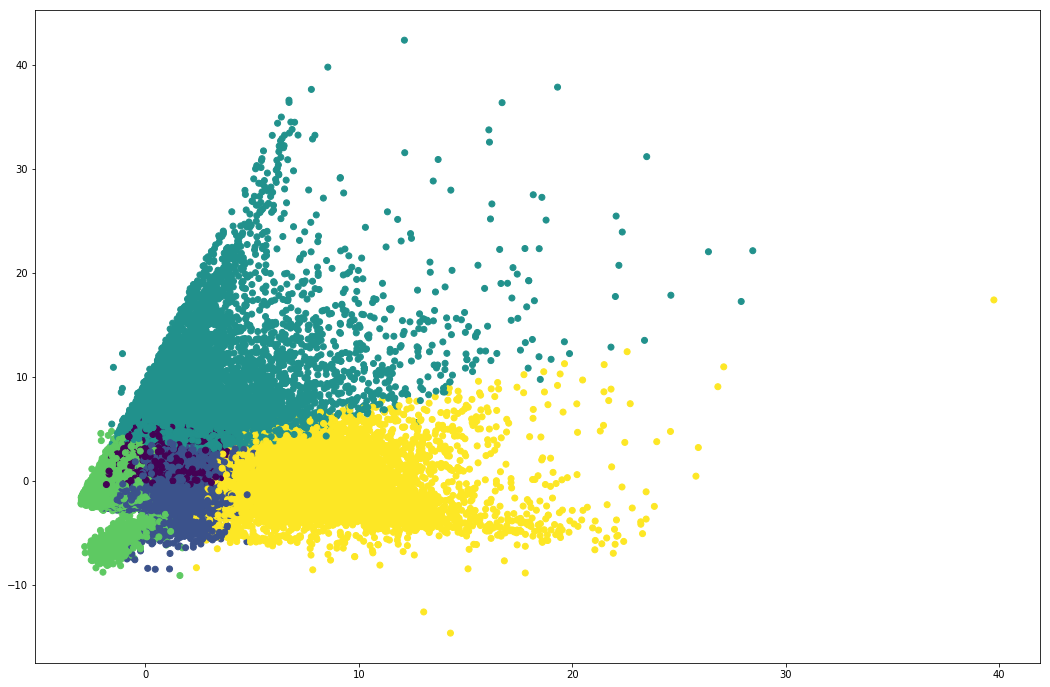

In [157]:
plt.scatter(targert3['X'], targert3['Y'],c =labels)

In [158]:
pd.concat([df[df['labels']==3].describe().T['50%'],df[df['labels']==0].describe().T['mean'], df1[df1['labels']==0].describe().T['50%'],df1[df1['labels']==0].describe().T['mean'], \
           df1[df1['labels']==1].describe().T['50%'],df1[df1['labels']==1].describe().T['mean'], df1[df1['labels']==2].describe().T['50%'], df1[df1['labels']==2].describe().T['mean'], \
           df1[df1['labels']==3].describe().T['50%'],df1[df1['labels']==3].describe().T['mean'], df1[df1['labels']==4].describe().T['50%'],df1[df1['labels']==4].describe().T['mean']],axis=1).to_csv('CommonMean6-Promo.csv')

In [159]:
print(df[df['labels']==3].shape[0])
print(df1[df1['labels']==0].shape[0])
print(df1[df1['labels']==1].shape[0])
print(df1[df1['labels']==2].shape[0])
print(df1[df1['labels']==3].shape[0])
print(df1[df1['labels']==4].shape[0])


36644
66751
159365
12700
217413
29851


In [2]:
#повторим с данными только за 17й и 18 года & сразу выделим первый залог
sql_query = "SELECT Code, \
      [PartnerID] \
      ,IIf([Sex]='M',1,IIf([Sex]='F',0,NULL)) Sex \
      ,Age,CreditCondition,LombardRating,SumAmountzb,AVGAmountzb,ZB,Good,PercentGood,IIF(PromotionID = 0,0,1) Promo,QntNew,QntPerez,QntOSN,QntBuyUp, \
      AVGDneyZaloga,AVGDneySProshZB,AVGWeightGross,AVGCostPerGram,AVGCost,AVGPercentPerDay,MINPercentPerDay,MAXPercentPerDay, \
      OverPayAmount,BudetSledVisit3M,BudetSledVisit6M,BudetSledVisit12M \
  FROM [Gold585].[dbo].[CommonTable] a \
  Where IssueDate > convert(datetime,'2017-11-01') and IssueDate < convert(datetime,'2018-06-01') and Category in ('Новая cсуда')\
  and IssueDateTime = (select max(IssueDateTime) from [CommonTable] b where a.[PartnerID] =b.[PartnerID] and b.Category in ('Новая cсуда') and b.IssueDate < convert(datetime,'2018-06-01'))"
data11 = pd.read_sql(sql_query,conn)

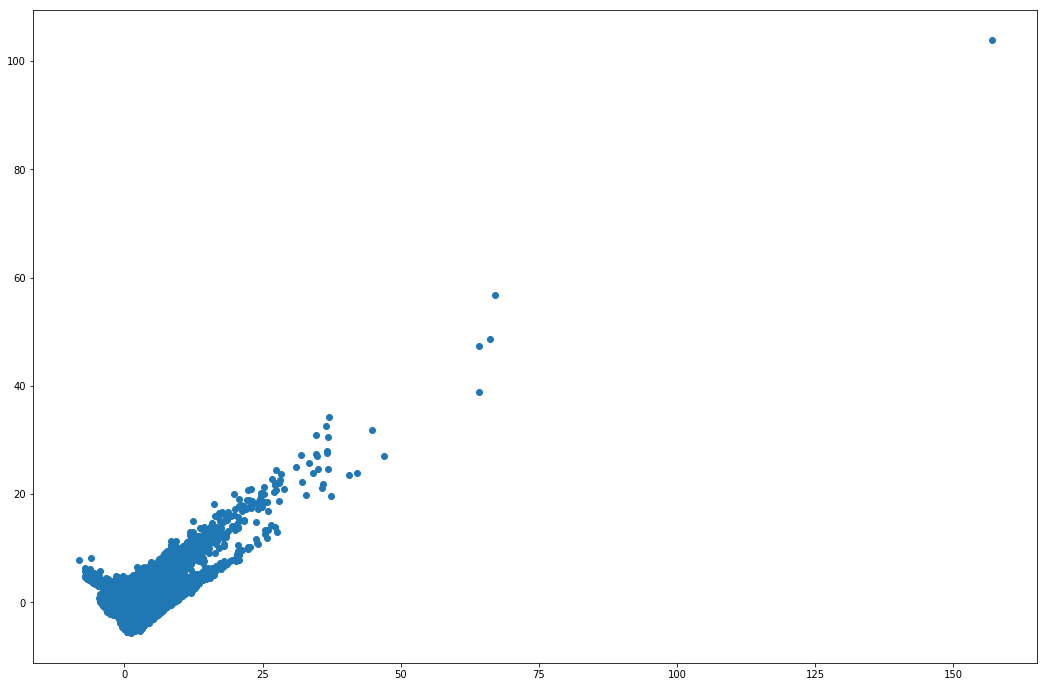

In [3]:
df11 = data11[data11['ZB']!=1].fillna(0)
df11.reset_index(drop=True,inplace = True)
target11=df11.drop(['Code','PartnerID','BudetSledVisit3M','BudetSledVisit6M','BudetSledVisit12M'], axis=1)
target11 = pd.get_dummies(target11, columns = ['Sex','CreditCondition','LombardRating'])
X11 = StandardScaler().fit_transform(target11)

from sklearn.decomposition import PCA
# PCA
pca = PCA(n_components=2) #HOW MANY AXIS DO WE WANT
pca.fit(X11)
targert22 = pca.transform(X11)

# TABLE WITH COMBINATIONS OF OLD FEATURES
#print(pd.DataFrame(pca.components_,columns=target11.columns, index = ['PC-1','PC-2']))#NUM INDEX EQUAL TO ALALALALAALL
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 18
fig_size[1] = 12

plt.scatter(targert22[:, 0], targert22[:, 1])

In [ ]:
from sklearn.cluster import SpectralClustering

#kmeans = KMeans(n_clusters=5, random_state=42).fit(X11)
kmeans = SpectralClustering(n_clusters=5)

labels11 = kmeans.fit_predict(X11)

df11['labels']=pd.DataFrame(labels11)
targert22 = pd.DataFrame(targert22,columns=('X','Y'))
targert22['L'] = pd.DataFrame(labels11)

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 18
fig_size[1] = 12

plt.scatter(targert22['X'], targert22['Y'],c =labels11)

In [275]:
pd.concat([df11[df11['labels']==0].describe().T['50%'],df11[df11['labels']==0].describe().T['mean'], \
           df11[df11['labels']==1].describe().T['50%'],df11[df11['labels']==1].describe().T['mean'], \
           df11[df11['labels']==2].describe().T['50%'],df11[df11['labels']==2].describe().T['mean'], \
           df11[df11['labels']==3].describe().T['50%'],df11[df11['labels']==3].describe().T['mean'], \
           df11[df11['labels']==4].describe().T['50%'],df11[df11['labels']==4].describe().T['mean']],axis=1).to_csv('2017-2018 - two clastering-2.csv')

In [276]:
#удалим кластер с выбросами и проанализируем еще раз

print(df11[df11['labels']==0].shape[0])
print(df11[df11['labels']==1].shape[0])
print(df11[df11['labels']==2].shape[0])
print(df11[df11['labels']==3].shape[0])
print(df11[df11['labels']==4].shape[0])

49403
72221
33659
1230
29837


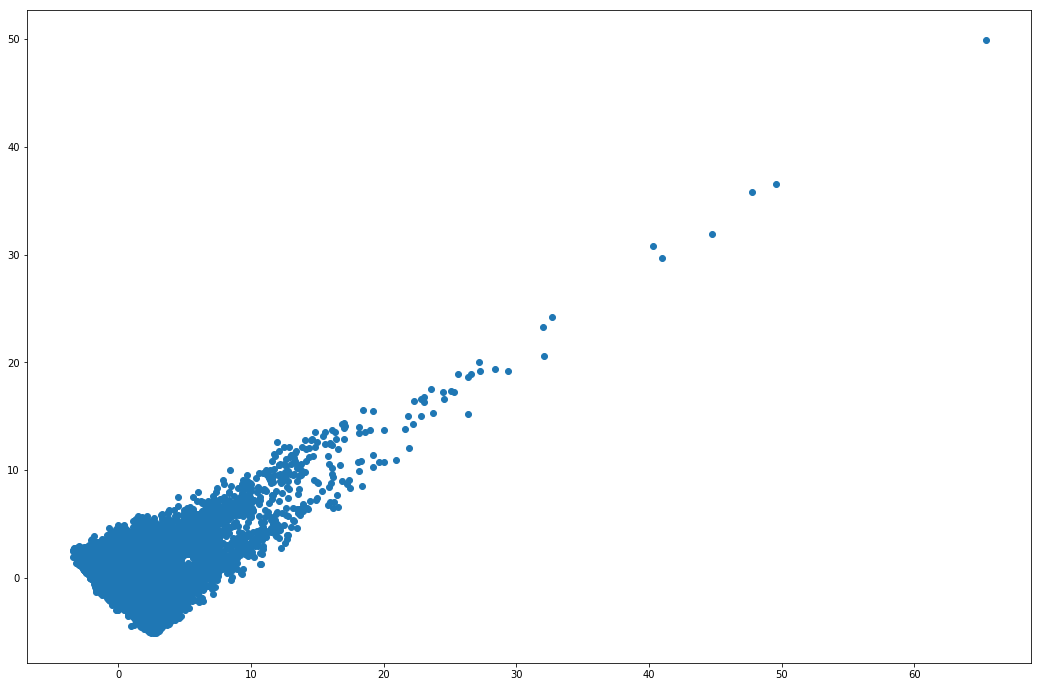

In [278]:
df11 = data11[data11['ZB']==1].fillna(0)
df11.reset_index(drop=True,inplace = True)
target11=df11.drop(['Code','PartnerID','BudetSledVisit3M','BudetSledVisit6M','BudetSledVisit12M'], axis=1)
target11 = pd.get_dummies(target11, columns = ['Sex','CreditCondition','LombardRating'])
X11 = StandardScaler().fit_transform(target11)

from sklearn.decomposition import PCA
# PCA
pca = PCA(n_components=2) #HOW MANY AXIS DO WE WANT
pca.fit(X11)
targert22 = pca.transform(X11)

# TABLE WITH COMBINATIONS OF OLD FEATURES
#print(pd.DataFrame(pca.components_,columns=target11.columns, index = ['PC-1','PC-2']))#NUM INDEX EQUAL TO ALALALALAALL
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 18
fig_size[1] = 12

plt.scatter(targert22[:, 0], targert22[:, 1])

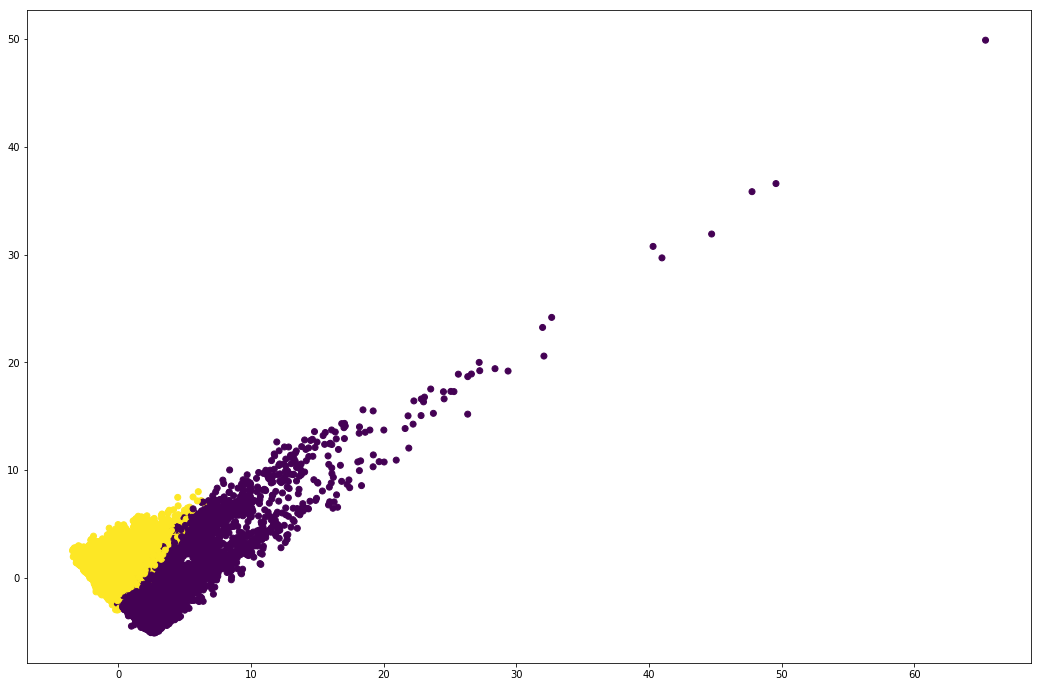

In [279]:
kmeans = KMeans(n_clusters=2, random_state=42).fit(X11)
labels11 = kmeans.predict(X11)

df11['labels']=pd.DataFrame(labels11)
targert22 = pd.DataFrame(targert22,columns=('X','Y'))
targert22['L'] = pd.DataFrame(labels11)

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 18
fig_size[1] = 12

plt.scatter(targert22['X'], targert22['Y'],c =labels11)

In [280]:

print(df11[df11['labels']==0].shape[0])
print(df11[df11['labels']==1].shape[0])

12704
47314


In [281]:
pd.concat([ df11[df11['labels']==0].describe().T['50%'],df11[df11['labels']==0].describe().T['mean'], \
            df11[df11['labels']==1].describe().T['50%'],df11[df11['labels']==1].describe().T['mean']],axis=1).to_csv('2017-2018 - two clastering-1.csv')

In [214]:
pd.concat([df11[(df11['labels']==2) & (df11['ZB']==1)].describe().T['50%'],df11[(df11['labels']==2) & (df11['ZB']==1)].describe().T['mean'], df11[(df11['labels']==2) & (df11['ZB']!=1)].describe().T['50%'],df11[(df11['labels']==2) & (df11['ZB']!=1)].describe().T['mean'], \
           df11[df11['labels']==0].describe().T['50%'],df11[df11['labels']==0].describe().T['mean'], df11[df11['labels']==3].describe().T['50%'], df11[df11['labels']==3].describe().T['mean'], \
           df11[df11['labels']==4].describe().T['50%'],df11[df11['labels']==4].describe().T['mean'], df11[df11['labels']==5].describe().T['50%'],df11[df11['labels']==5].describe().T['mean'], \
           df11[df11['labels']==1].describe().T['50%'],df11[df11['labels']==1].describe().T['mean']],axis=1).to_csv('2017-2018.csv')

In [5]:
import sompylib.som_structure as SOM

ModuleNotFoundError: No module named 'sompylib'

In [6]:
import numpy as np
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.utils import check_X_y
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics.cluster.unsupervised import check_number_of_labels

def silhouette_samples_memory_saving(X, labels, metric='euclidean', **kwds):
    X, labels = check_X_y(X, labels, accept_sparse=['csc', 'csr'])
    le = LabelEncoder()
    labels = le.fit_transform(labels)
    check_number_of_labels(len(le.classes_), X.shape[0])

    unique_labels = le.classes_
    n_samples_per_label = np.bincount(labels, minlength=len(unique_labels))

    # For sample i, store the mean distance of the cluster to which
    # it belongs in intra_clust_dists[i]
    intra_clust_dists = np.zeros(X.shape[0], dtype=X.dtype)

    # For sample i, store the mean distance of the second closest
    # cluster in inter_clust_dists[i]
    inter_clust_dists = np.inf + intra_clust_dists

    for curr_label in range(len(unique_labels)):

        # Find inter_clust_dist for all samples belonging to the same
        # label.
        mask = labels == curr_label

        # Leave out current sample.
        n_samples_curr_lab = n_samples_per_label[curr_label] - 1
        if n_samples_curr_lab != 0:
            intra_distances = pairwise_distances(X[mask, :], metric=metric, **kwds)
            intra_clust_dists[mask] = np.sum(intra_distances, axis=1) / n_samples_curr_lab

        # Now iterate over all other labels, finding the mean
        # cluster distance that is closest to every sample.
        for other_label in range(len(unique_labels)):
            if other_label != curr_label:
                other_mask = labels == other_label
                inter_distances = pairwise_distances(X[mask, :], X[other_mask, :], metric=metric, **kwds)
                other_distances = np.mean(inter_distances, axis=1)
                inter_clust_dists[mask] = np.minimum(inter_clust_dists[mask], other_distances)

    sil_samples = inter_clust_dists - intra_clust_dists
    sil_samples /= np.maximum(intra_clust_dists, inter_clust_dists)
    # score 0 for clusters of size 1, according to the paper
    sil_samples[n_samples_per_label.take(labels) == 1] = 0

    return sil_samples

In [ ]:
from sklearn.cluster import KMeans
mas = []
for k in range(2, 8):
    kmeans = KMeans(n_clusters=k, random_state=1).fit(X11)
    labels = kmeans.predict(X11)
    mas.append(silhouette_samples_memory_saving(X11, kmeans.labels_))
    print((silhouette_samples_memory_saving(X11, kmeans.labels_)))

plt.plot(range(2, 8), mas, marker='s');
plt.xlabel('$k$')
plt.ylabel('$J(C_k)$');

In [6]:
from scipy.cluster.hierarchy import linkage, dendrogram

In [13]:
samples = X
 
# Реализация иерархической кластеризации при помощи функции linkage
mergings = linkage(samples, method='complete')
 
# Строим дендрограмму, указав параметры удобные для отображения
dendrogram(mergings,
           labels=varieties,
           leaf_rotation=90,
           leaf_font_size=6,
           )
 
plt.show()

MemoryError: 